In [19]:
# %% [code]
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import zoom, distance_transform_edt
from skimage import segmentation
from skimage.feature import peak_local_max
# For scikit-image versions 0.12.3 and later
from skimage.measure import label

# For visualization in notebooks
%matplotlib inline


In [15]:
# %% [code]
def load_itk_image(mhd_path):
    """
    Load a .mhd image using SimpleITK.
    
    Parameters:
      mhd_path: Path to the .mhd file.
      
    Returns:
      image: A 3D NumPy array of the image.
      spacing: The voxel spacing (z, y, x) as a NumPy array.
    """
    itk_img = sitk.ReadImage(mhd_path)
    image = sitk.GetArrayFromImage(itk_img)  # shape: (slices, height, width)
    spacing = np.array(list(reversed(itk_img.GetSpacing())))  # convert spacing to (z, y, x)
    return image, spacing

# Adjust the path to point to one of the mhd files in your dataset.
mhd_path = '/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
image, spacing = load_itk_image(mhd_path)
print("Image shape:", image.shape)
print("Original spacing (z, y, x):", spacing)


Image shape: (121, 512, 512)
Original spacing (z, y, x): [2.5        0.76171899 0.76171899]


In [16]:
# %% [code]
def resample(image, spacing, new_spacing=[1, 1, 1]):
    """
    Resample the image to new voxel spacing.
    
    Parameters:
      image: 3D image array.
      spacing: Original voxel spacing (z, y, x).
      new_spacing: Desired voxel spacing.
      
    Returns:
      image_resampled: The resampled image.
      new_shape: The shape of the resampled image.
    """
    spacing = np.array(spacing, dtype=np.float32)
    new_spacing = np.array(new_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor).astype(int)
    real_resize_factor = new_shape / image.shape
    print("Original shape:", image.shape, "Resampled shape:", new_shape)
    image_resampled = zoom(image, real_resize_factor, mode='nearest')
    return image_resampled, new_shape

image_resampled, new_shape = resample(image, spacing)
print("Resampled image shape:", image_resampled.shape)


Original shape: (121, 512, 512) Resampled shape: [302 390 390]
Resampled image shape: (302, 390, 390)


In [21]:
from skimage.measure import label

def lung_segmentation_watershed(image_slice, threshold=-320):
    """
    Segment the lungs on a single slice using a watershed marker-based approach.
    
    Parameters:
      image_slice: 2D image array (one slice in HU).
      threshold: HU threshold to separate lung (air) from tissue.
    
    Returns:
      lung_mask: 2D binary mask of the lung region.
    """
    # Create binary mask: lung tissues are lower than threshold (air is dark in CT)
    binary = image_slice < threshold

    # Compute Euclidean distance transform on binary mask
    distance = distance_transform_edt(binary)

    # Identify local maxima as markers for watershed segmentation.
    # peak_local_max now returns coordinates, so we need to build a binary mask.
    local_maxi_coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
    
    # Create binary mask for local maxima
    local_maxi = np.zeros_like(distance, dtype=bool)
    if local_maxi_coords.size > 0:
        local_maxi[tuple(local_maxi_coords.T)] = True

    # Label the local maxima to serve as markers
    markers = label(local_maxi)[0]  # Only take the labeled image
    
    # Apply watershed on the negative distance map
    labels_ws = segmentation.watershed(-distance, markers, mask=binary)
    
    # Choose the label with the largest area (assuming it's the lung region)
    unique_labels = np.unique(labels_ws)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background
    if unique_labels.size > 0:
        volumes = [np.sum(labels_ws == label) for label in unique_labels]
        lung_label = unique_labels[np.argmax(volumes)]
        lung_mask = labels_ws == lung_label
        return lung_mask.astype(np.int8)
    else:
        return np.zeros_like(image_slice, dtype=np.int8)

# For visualization, apply segmentation to a central slice.
slice_idx = image_resampled.shape[0] // 2
lung_mask_slice = lung_segmentation_watershed(image_resampled[slice_idx])
print("Lung mask computed for slice:", slice_idx)


Lung mask computed for slice: 151


In [22]:
# %% [code]
def normalize(image, min_bound=-1000.0, max_bound=400.0):
    """
    Normalize the image by clipping to a specified range and then zero-centering.
    
    Parameters:
      image: 3D image array in HU.
      min_bound: Minimum HU value.
      max_bound: Maximum HU value.
    
    Returns:
      Normalized image.
    """
    image = np.clip(image, min_bound, max_bound)
    image = (image - np.mean(image)) / np.std(image)
    return image

image_normalized = normalize(image_resampled)
print("Normalization complete.")


Normalization complete.


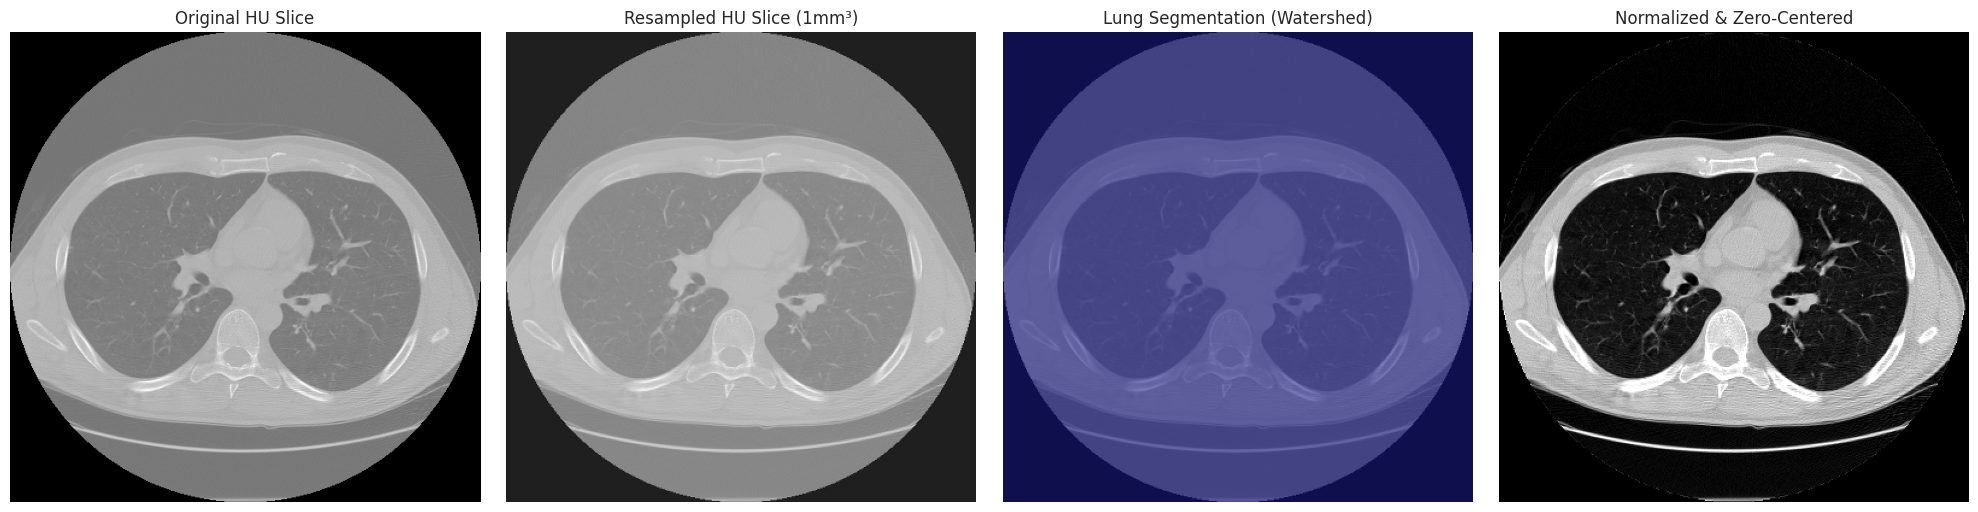

In [23]:
# %% [code]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original image slice from the loaded mhd (before resampling)
mid_slice_orig = image[image.shape[0]//2]
axs[0].imshow(mid_slice_orig, cmap='gray')
axs[0].set_title('Original HU Slice')

# Resampled image slice
axs[1].imshow(image_resampled[slice_idx], cmap='gray')
axs[1].set_title('Resampled HU Slice (1mm³)')

# Lung segmentation overlay on the resampled image slice
axs[2].imshow(image_resampled[slice_idx], cmap='gray')
axs[2].imshow(lung_mask_slice, cmap='jet', alpha=0.5)
axs[2].set_title('Lung Segmentation (Watershed)')

# Normalized image slice
axs[3].imshow(image_normalized[slice_idx], cmap='gray')
axs[3].set_title('Normalized & Zero-Centered')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()
